In [12]:
#Import modules

import pandas as pd
# from IPython.display import display, HTML
# from numpy import log10, nan, inf, random, clip, arange

# path = './../export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

# display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from numpy import arange, log10

from functions import chunk, agg, finalize
tunique = dd.Aggregation('tunique', chunk, agg,finalize)
first = dd.Aggregation('first', chunk, agg,finalize)

### Prices and quantities

In [4]:
drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'CN ID 8', u'PYOD', u'VART', u'MASSE', u'USUP', u'USUP_MT']

df_list = []

for y in range(1997, 2005):
    df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
            usecols = map(colname_no.get, columns),
            delimiter = ';', header = None, dtype = {9: 'object'}).fillna('')]

data_ = dd.concat(df_list)
data_.columns = columns

In [5]:
# with ProgressBar():
#     df = data_.compute()

In [5]:
grouped = data_.loc[data_.FLUX == 2].groupby(['ID', 'CN ID 8', 'MONTH', 'YEAR'])

In [12]:
# df = 
# df = df.sort_index().reset_index()

with ProgressBar():
    out = grouped[['VART', 'MASSE']].sum().compute()
out.to_csv('units_bkp.csv')

with ProgressBar():
    out_2 = data_.loc[data_.FLUX == 2].groupby(['ID', 'CN ID 8']).agg(
        {'VART': sum, 'MASSE': sum, 'USUP': tunique, 'USUP': first, 'USUP_MT': sum}).compute()
out_2.to_csv('units_bkp.csv')

[########################################] | 100% Completed |  5min 47.3s


In [8]:
df_ = out.sort_index().reset_index()
# .diff()

NameError: name 'out' is not defined

In [ ]:
dif = df_.diff()

In [ ]:
dif.loc[(dif.ID == 0) & (dif['CN ID 8'] == 0) & (dif['MONTH'] == 0) & (dif.YEAR == 1)]

## Firm sizes

In [22]:
drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'VAT', u'VART']

df_list = []

for y in range(2010, 2014):
    df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
            usecols = map(colname_no.get, columns),
            delimiter = ';', header = None, dtype = {9: 'object'})]

data = dd.concat(df_list)
data.columns = columns
data['IMPORT'] = data['FLUX'] % 2


In [23]:
firm_sizes = data.groupby(['ID', 'IMPORT','YEAR'])[['VART']].sum().reset_index()
buyr_sizes = data.groupby(['VAT', 'IMPORT','YEAR'])[['VART']].sum().reset_index()


In [24]:
with ProgressBar():
    firm_sizes = firm_sizes.compute()
    buyr_sizes = buyr_sizes.loc[buyr_sizes.YEAR > 2010].compute()
    
firm_sizes['log_VART'] = log10(firm_sizes.VART)
buyr_sizes['log_VART'] = log10(buyr_sizes.VART)

firm_sizes.to_csv('firm_sizes.csv', index = False)
buyr_sizes.to_csv('buyr_sizes.csv', index = False)

[########################################] | 100% Completed |  4min 31.6s
[########################################] | 100% Completed |  7min 10.8s


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


In [4]:
firm_sizes = pd.read_csv('firm_sizes.csv')
buyr_sizes = pd.read_csv('buyr_sizes.csv')

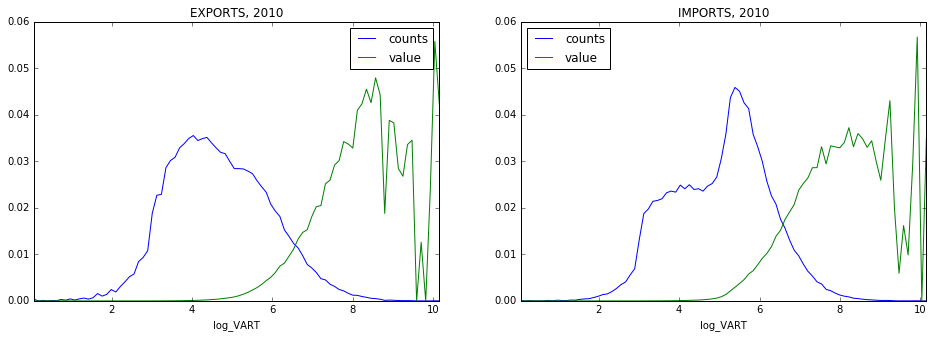

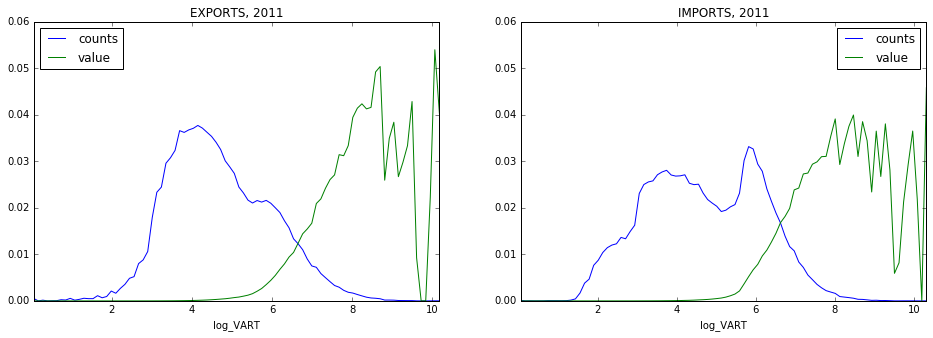

In [5]:
from numpy import inf, nan

fs_df = firm_sizes

for y in [2010, 2011]:
    fig, axs = plt.subplots(1, 2, figsize = (16, 5))
    for i in [0, 1]:
        fs_df_slice = fs_df.loc[(fs_df.YEAR == y) & (fs_df.IMPORT == i)].replace(-inf, nan).dropna()
        fs_df_slice['bin'], bins_x = pd.cut(fs_df_slice['log_VART'], 90, retbins=True)

        fs_ct_val = fs_df_slice.groupby('bin').agg({'ID': 'count', 'VART': sum}).rename(columns = {'ID': 'counts', 'VART': 'value'})

        fs_ct_val/=fs_ct_val.sum()
        ax = axs[i]
        fs_ct_val['log_VART'] = (bins_x[:-1] + bins_x[1:])/2.
        fs_ct_val.plot(x = 'log_VART', y = 'counts', ax = ax)
        fs_ct_val.plot(x = 'log_VART', y = 'value', ax = ax)
        ax.set_title('IMPORTS, '+str(y)) if i == 1 else ax.set_title('EXPORTS, '+str(y))
        ax.set_ylim(0, 0.06)

### Value by buyer, seller size

In [6]:
# drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

# colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
#        u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

# colname_no = dict(zip(colnames, range(18)))
# columns = [u'YEAR', u'FLUX', u'ID', u'VAT', u'VART']

# df_list = []

# for y in range(1997, 2014):
#     df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
#             usecols = map(colname_no.get, columns),
#             delimiter = ';', header = None, dtype = {9: 'object'})]

# data = dd.concat(df_list)
# data.columns = columns
# data['IMPORT'] = data['FLUX'] % 2

# links = data.groupby(['IMPORT','YEAR','ID','VAT'])['VART'].sum().reset_index()


In [7]:
# with ProgressBar():
#     out = links.compute()
# out.to_csv('buyer_seller_links.csv', index = False)

[########################################] | 100% Completed | 16min 41.3s


In [6]:
links = pd.read_csv('./buyer_seller_links.csv')
links = links.loc[links.VART > 1000]

links['log_VART'] = log10(links.VART)#.replace(-inf, nan).dropna()
# links['bin'], bins_x = pd.cut(links['log_VART'], 90, retbins=True)

In [7]:
links_y = links.loc[links.YEAR > 2010].groupby(['ID', 'VAT'])[['VART']].mean().reset_index()

ID_chars = links_y.groupby('ID').agg({'VAT': 'nunique', 'VART': sum}).rename(columns = {'VART': 'log_VART', 'VAT': 'ID_degree'})
ID_chars = log10(ID_chars).reset_index()

VAT_chars = links_y.groupby('VAT').agg({'ID': 'nunique', 'VART': sum}).rename(columns = {'VART': 'log_VART', 'ID': 'VAT_degree'})
VAT_chars = log10(VAT_chars).reset_index()

# firm_sizes = pd.read_csv('firm_sizes.csv')
# buyr_sizes = pd.read_csv('buyr_sizes.csv')

# firm_sizes_y = firm_sizes.loc[(firm_sizes.YEAR == 2013) & (firm_sizes.IMPORT == 0)]
# buyr_sizes_y = buyr_sizes.loc[(buyr_sizes.YEAR == 2013) & (buyr_sizes.IMPORT == 0)]

In [8]:
links_val = links_y.merge(ID_chars[['ID','log_VART', 'ID_degree']], on = 'ID').merge(VAT_chars[['VAT', 'log_VART', 'VAT_degree']], on = 'VAT')
links_val = links_val.rename(columns = {'log_VART_x': 'log_VART_ID', 'log_VART_y': 'log_VART_VAT'})

In [113]:
print links_val.VAT_degree.max()
print links_val.ID_degree.max()

3.50609895993
4.13557785334


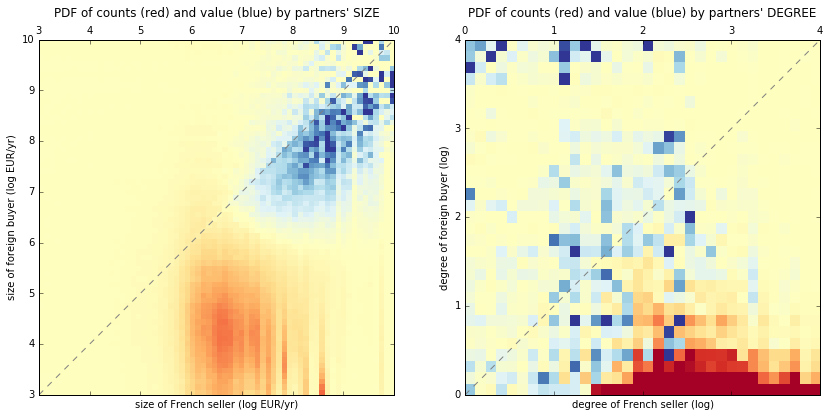

In [22]:
from numpy import arange
from matplotlib.colors import Normalize

bins = arange(3, 10, .1)
links_val['val_x_bin'] = pd.cut(links_val['log_VART_ID'], bins)
links_val['val_y_bin'] = pd.cut(links_val['log_VART_VAT'], bins)

bins_d = arange(-.1, 4, .1)
links_val['deg_x_bin'] = pd.cut(links_val['ID_degree'], bins_d)
links_val['deg_y_bin'] = pd.cut(links_val['VAT_degree'], bins_d)

fig, axs = plt.subplots(1, 2, figsize = (14, 7))

for i in [0, 1]:

    if i == 0:
        result = links_val.groupby(['val_x_bin','val_y_bin']).agg({'log_VART_ID': 'mean', 'log_VART_VAT': 'mean', 
                                                           'VART': 'sum', 'ID': 'count'})
    elif i == 1:
        result = links_val.groupby(['deg_x_bin','deg_y_bin']).agg({'ID_degree': 'mean', 'VAT_degree': 'mean', 
                                                           'VART': 'sum', 'ID': 'count'}) #ID is just a counter

    result['PDF_value'] = result['VART']/result['VART'].sum()
    result['PDF_count'] = result['ID']/result['ID'].sum() #ID is just a counter

    result_table = result.unstack(0).sort_index(ascending = False)

    value = result_table['PDF_value'].fillna(0).values
    count = result_table['PDF_count'].fillna(0).values

    ax = axs[i]
    extent = [(3, 10, 3, 10), (0, 4, 0, 4)][i]
    ax.matshow(value - count, extent=extent, cmap=plt.cm.RdYlBu, vmin = -0.003, vmax = .003)

axs[0].plot([3, 10], [3, 10], c = '.5', linestyle = '--')
axs[1].plot([0, 4], [0, 4], c = '.5', linestyle = '--')

axs[0].set_xlabel('size of French seller (log EUR/yr)')
axs[0].set_ylabel('size of foreign buyer (log EUR/yr)')
axs[0].set_title("PDF of counts (red) and value (blue) by partners' SIZE")
axs[1].set_xlabel('degree of French seller (log)')
axs[1].set_ylabel('degree of foreign buyer (log)')
axs[1].set_title("PDF of counts (red) and value (blue) by partners' DEGREE")
plt.show()

In [23]:
# Save just the portion _inside_ the second axis's boundaries
extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('./Figures/partn_size_val_ct.png', bbox_inches=extent.expanded(1.2, 1.2))

In [ ]:
# # dd.read_csv('2014-*.csv')

# # drive_path = './../export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'
# drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

# n_bins = 20
# df_list = n_bins * [ 0 ]

# for dataset_i in range(n_bins):
#     df_list[dataset_i] = dd.read_csv(drive_path+'/samplings/YMxpb_size20'+str(dataset_i).zfill(2)+'.csv')#,
# #                                     usecols = ['YEAR','ID','VAT','VART_sum'])

# data = dd.concat(df_list)
# data = data.groupby(['YEAR','ID','VAT'])['VART_sum'].sum().reset_index()

In [ ]:
# with ProgressBar():
#     out = data.compute()
# out.to_csv('buyer_seller_links.csv', index = False)

# data = dd.from_pandas(out, npartitions = 100)

In [24]:
links = pd.read_csv('./buyer_seller_links.csv')
links = links.loc[links.VART > 1000]
links_count = links.groupby('YEAR').agg({'VART': 'count', 'ID': 'nunique', 'VAT': 'nunique'})
links_count = links_count.rename(columns = {'VART': 'pairs', 'ID': 'FR sellers', 'VAT': 'foreign buyers'})
links_pct_change = 100*links_count.pct_change().round(4).fillna('')

In [28]:
links_summary = pd.concat([links_count.round(-3),links_pct_change], axis = 1)
links_summary.columns = pd.MultiIndex.from_product([['count', 'yearly pct change'], links_count.columns])
links_summary

count                           yearly pct change             \
        pairs FR sellers foreign buyers             pairs FR sellers   
YEAR                                                                   
1997   825000      52000         352000                                
1998   853000      53000         356000              3.46       2.53   
1999   879000      54000         367000              3.06       1.76   
2000   901000      54000         381000              2.49        0.3   
2001   888000      50000         384000             -1.46      -7.75   
2002   899000      49000         391000              1.31      -3.44   
2003   900000      48000         398000              0.02      -0.53   
2004   955000      49000         426000              6.15       0.85   
2005   974000      48000         430000                 2      -0.54   
2006   981000      47000         434000              0.66      -3.11   
2007  1002000      46000         451000               2.2      -2.01   
2008   986000      45000         448000             -1.63       -1.8   
2009   930000      43000         430000             -5.63      -4.32   
2010   946000      42000         437000              1.69      -1.69   
2011   835000      27000         406000            -11.76     -37.15   
2012   830000      25000         405000             -0.56      -6.91   
2013   829000      25000         403000             -0.07      -0.31   

                     
     foreign buyers  
YEAR                 
1997                 
1998           1.15  
1999           3.05  
2000           3.84  
2001            0.7  
2002           1.73  
2003           1.77  
2004           7.12  
2005           0.88  
2006           1.06  
2007           3.81  
2008          -0.66  
2009          -3.95  
2010           1.63  
2011           -7.1  
2012          -0.36  
2013           -0.3

In [29]:
print(links_summary.to_latex())

\begin{tabular}{lrrrlll}
\toprule
{} & \multicolumn{3}{l}{count} & \multicolumn{3}{l}{yearly pct change} \\
{} &    pairs & FR sellers & foreign buyers &             pairs & FR sellers & foreign buyers \\
YEAR &          &            &                &                   &            &                \\
\midrule
1997 &   825000 &      52000 &         352000 &                   &            &                \\
1998 &   853000 &      53000 &         356000 &              3.46 &       2.53 &           1.15 \\
1999 &   879000 &      54000 &         367000 &              3.06 &       1.76 &           3.05 \\
2000 &   901000 &      54000 &         381000 &              2.49 &        0.3 &           3.84 \\
2001 &   888000 &      50000 &         384000 &             -1.46 &      -7.75 &            0.7 \\
2002 &   899000 &      49000 &         391000 &              1.31 &      -3.44 &           1.73 \\
2003 &   900000 &      48000 &         398000 &              0.02 &      -0.53 &           1.

### Buyers and selers by foreign country

In [9]:
import dask.dataframe as dd
drive_path = './../../../../media/miglesia/Elements/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

colnames = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'DEPT', u'CN ID 8', u'CPA6',
       u'PYOD', u'PAYP', u'VAT', u'PRIFAC', u'DEVFAC', u'VFTE', u'VART', u'D_MASSE', u'MASSE', u'USUP', u'USUP_MT']

colname_no = dict(zip(colnames, range(18)))
columns = [u'YEAR', u'MONTH', u'FLUX', u'ID', u'PYOD', u'VART']

df_list = []

for y in range(1997, 2014):
    df_list += [dd.read_table(drive_path+'/DP1610_MAASTRICHT1_'+str(y)+'.txt', 
            usecols = map(colname_no.get, columns),
            delimiter = ';', header = None, dtype = {9: 'object'})]

data = dd.concat(df_list)
data.columns = columns
data['IMPORT'] = data['FLUX'] % 2

data_by_dest = data.groupby(['IMPORT','YEAR','ID','PYOD'])['VART'].sum().reset_index()


In [10]:
result = data_by_dest.groupby(['PYOD', 'YEAR']).agg({'ID': tunique, 'VART': 'sum'})

In [13]:
with ProgressBar():
    out = result.compute()
    
out.to_csv('./destination.csv')

[########################################] | 100% Completed | 14min 24.8s


### Load

In [54]:
import pandas as pd
out = pd.read_csv('./destination.csv', index_col=[0, 1])

by_size = out.reset_index().groupby(['PYOD'])[['VART']].mean().sort_values(by = 'VART', ascending = False)
largest = by_size.head(15).index

In [57]:
pd.options.display.float_format = '${:,.2f}'.format
df = out.loc[largest].unstack()['VART']/1e9
df.reindex(columns)
df[2014] = 0
df[2015] = 165
df.T.round(2).style.bar(color='#5fba7d')


In [60]:
out

VART    ID
PYOD YEAR                  
AD   1997   283153579  4204
     1998   305764758  4282
     1999   312887082  4161
     2000   311107379  3924
     2001   317297546  3935
     2002   333720746  3811
     2003   333840589  3634
     2004   339832417  3594
     2005   348951051  3456
     2006   340997401  3241
     2007   272412054  3084
     2008   280967521  2751
     2009   238315152  2604
     2010   243351993  3171
     2011   232272875  2882
     2012   215702974  2720
     2013   206197255  2698
AE   1997   984986518  4477
     1998  1212073790  4596
     1999  1777173376  4574
     2000  2379028514  4881
     2001  3020608900  5278
     2002  2817755749  5515
     2003  3340663611  5132
     2004  3108008538  5370
     2005  3384314295  5709
     2006  4511430010  6149
     2007  4619835220  6356
     2008  4504397827  6735
     2009  4072329697  6254
...               ...   ...
ZM   2001    16980360   141
     2002    19699421   126
     2003    19799869   136
     2004    33097988   147
     2005    26204445   146
     2006    19034469   174
     2007    25107393   184
     2008    31774832   218
     2009    16197198   148
     2010    33953439   181
     2011    46148755   204
     2012    47073011   225
     2013    28102349   213
ZW   1997    84706397   547
     1998    75628842   495
     1999    81001693   498
     2000    62335714   452
     2001    54227821   380
     2002    37692617   326
     2003    37354373   265
     2004    27549395   245
     2005    23658383   221
     2006    18806360   223
     2007    27695832   213
     2008    23804298   178
     2009    17223399   163
     2010    26356704   217
     2011    34364761   230
     2012    40861653   232
     2013    39242064   225

[4046 rows x 2 columns]

In [64]:
pd.options.display.float_format = '${:,.2f}'.format
df = out.loc[largest].unstack()['ID']
df.reindex(columns)
df[2014] = 0
df[2015] = 65000
df.T.round(-2).style.bar(color='#d65f5f')


In [ ]:
#Largest markets in sellers
(out.loc[largest].unstack()['ID'].T).round(-1).astype(int).reindex(largest, axis = 1)

### Degree distribution

In [ ]:
links['PERIOD'] = (links['YEAR'] - 1996) // 2

In [ ]:
degrees = links.groupby(['PERIOD', 'ID'])[['VAT']].nunique().rename(columns = {'VAT': 'ID_degree'})

In [ ]:
degrees['log_ID_degree'] = log10(degrees['ID_degree'])
degrees['bin_ID_degree'] = pd.cut(degrees['log_ID_degree'], arange(-.25, 4.5, 0.25))

In [ ]:
degree_dist = degrees.reset_index().groupby(['PERIOD', 'bin_ID_degree'])[['ID']].count()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize =(15, 6))

ax = axs[0]
for t in links['PERIOD'].unique():
    log10(degree_dist.loc[t]).reset_index().plot(marker = 'o', linewidth = 0, ax = ax, mec = 'None')

## Degree distribution and assortativity

In [ ]:
# window = 3
# assortativity_res = []
ID_degree_res = []
VAT_degree_res = []

for window in [3]:
    gap = (window-1)/2
    center_years = arange(2003, 2014, 2)
    print window

    for Yc in center_years:
        print Yc
        data_sec = data.loc[data.YEAR - Yc <= gap]
#         data_sec.groupby(['ID', 'VAT']).agg({'CN ID 8': tunique, 'VART_sum': sum })

        data_sec_by_ID = data_sec.groupby(['ID']).agg({'VAT': tunique, 'VART_sum': sum})

        ID_degree = data_sec_by_ID[['VAT']].reset_index()
        ID_degree.columns = [u'ID', u'ID_degree']
        ID_degree['center_year'] = Yc
        ID_degree['window'] = window
        
        with ProgressBar():
            ID_deg = ID_degree.compute()
            ID_deg['bin'] = pd.cut(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .25))
            ID_deg.to_csv('ID_deg_'+str(Yc)+'_'+str(window))
#         ID_degree_res += [ID_degree]     

#         ID_deg = pd.read_csv()
        sampling = ID_deg.groupby(['bin'], observed = True).apply(lambda x: x.sample(200, replace = True))

        data_sec_sample = data_sec.loc[data_sec.ID.isin(sampling['ID'].values)]
        data_sec_by_VAT = data_sec_sample.groupby(['VAT']).agg({'ID': tunique, 'VART_sum': sum})

        VAT_degree = data_sec_by_VAT[['ID']].reset_index()
        VAT_degree.columns = [u'VAT', u'VAT_degree']
        VAT_degree['center_year'] = Yc
        VAT_degree['window'] = window
        VAT_degree_res += [VAT_degree]
        with ProgressBar():
            VAT_deg = VAT_degree.compute()
            VAT_deg.to_csv('VAT_deg_'+str(Yc)+'_'+str(window))

In [ ]:
# VAT_degree_res = []
# for window in [1, 3, 5]:
#     gap = (window-1)/2
#     center_years = arange(1997, 2014, 2)
#     print window

#     for Yc in center_years:
    
#         ID_deg = pd.read_csv('./ID_deg_save.csv')
#         ID_deg = ID_deg.loc[(ID_deg.center_year == Yc) & (ID_deg.window == window)]
#         ID_deg['bin'] = pd.cut(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .25))
#         sampling = ID_deg.groupby(['bin'], observed = True).apply(lambda x: x.sample(50, replace = True))

#         data_sec_sample = data_sec.loc[data_sec.ID.isin(sampling['ID'].values)]
#         data_sec_by_VAT = data_sec_sample.groupby(['VAT']).agg({'ID': tunique, 'VART_sum': sum})

#         VAT_degree = data_sec_by_VAT[['ID']].reset_index()
#         VAT_degree.columns = [u'VAT', u'VAT_degree']
#         VAT_degree['center_year'] = Yc
#         VAT_degree['window'] = window
#         VAT_degree_res += [VAT_degree]
#         with ProgressBar():
#             VAT_deg = VAT_degree.compute()
#             VAT_deg.to_csv('VAT_deg_save_'+str(Yc)+'_'+str(window))

# #         assortativity_info = data_sec_sample.groupby(['ID', 'VAT'])[['VART_sum']].mean().reset_index().merge(
# #             ID_degree).merge(VAT_degree)
# #         assortativity_res += [assortativity_info]


In [ ]:
# ID_degree['bin'] = 
# pd.cut(log10(ID_degree['ID_degree']), bins = arange(-.49, 5.99, .5))

In [ ]:
# # ID_deg_res = dd.concat(ID_degree_res)
# # with ProgressBar():
# #     ID_deg = ID_deg_res.compute()

# VAT_deg_res = dd.concat(VAT_degree_res)
# with ProgressBar():
#     VAT_deg = VAT_deg_res.compute()

In [ ]:
# ID_deg.to_csv('./ID_deg_save.csv', index = False)
# VAT_deg.to_csv('./VAT_deg_save.csv', index = False)

In [ ]:
# plt.hist(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .25))
# plt.show()

In [ ]:
# # 
# # data_sec_sample.merge(ID_deg).merge(VAT_deg).compute()
# assortativity_info = data_sec_sample.groupby(['ID', 'VAT'])[['VART_sum']].mean().reset_index().merge(
#         ID_degree).merge(VAT_degree)

In [ ]:

# with ProgressBar():
#     assortativity_df = assortativity_info.compute()

In [ ]:
# assortativity_info.groupby(pd.cut(log10(assortativity_info['ID_degree']), bins = arange(-.49, 5.99, .5)))#['VAT_degree'].describe()

In [ ]:
# ID_deg['bin'] = pd.cut(log10(ID_deg['ID_degree']), bins = arange(-.49, 5.99, .5))
# ID_deg.groupby(['center_year','bin'])

In [ ]:
# data_sec_sample

In [ ]:
# # ID_deg.to_csv('degree_values.csv', index = False)

# from numpy import power
# left = power(10, arange(-.1, 5, .2)).round(1)
# right = power(10, arange(-.1, 5, .2) + .2).round(1)
# bins = pd.IntervalIndex.from_arrays(left, right)

# ID_deg_part = ID_deg.loc[(ID_deg.center_year == Yc) & (ID_deg.window == window)]
# ID_deg_part.groupby(pd.cut(ID_deg_part['ID_degree'], bins), observed = True).count().sort_index()

# sample_IDs = ID_deg_part.groupby(pd.cut(ID_deg_part['ID_degree'], bins), observed = True).apply(lambda x: x.sample(1000, replace = True))['ID'].values

# data_sec = data.loc[(data.YEAR - Yc <= gap) & (data.ID.isin(sample_IDs))]

    
# #.apply(lambda x: x.sample(5000, replace = True))['ID'].values

In [ ]:
# window = 3
# results = []
    
# gap = (3-1)/2
# center_years = arange(1997, 2014, 2)
# ID_degree_res = []
# VAT_degree_res = []



# for Yc in center_years:
#     VAT_deg_part = VAT_deg.loc[(VAT_deg.center_year == Yc) & (VAT_deg.window == window)]
#     ID_deg_part = ID_deg.loc[(ID_deg.center_year == Yc) & (ID_deg.window == window)]
#     sample_IDs = ID_deg_part.groupby(pd.cut(ID_deg_part['ID_degree'], bins), observed = True).apply(lambda x: x.sample(1000, replace = True))['ID'].values
    
#     data_sec = data.loc[(data.YEAR - Yc <= gap) & (data.ID.isin(sample_IDs))]

#     df_degrees = data_sec.merge(ID_deg_part, on = 'ID').merge(VAT_deg_part, on = ['VAT', 'center_year', 'window'])

#     results += [df_degrees]


In [ ]:
# summary_results = []

# for df_degrees in results:

#     with ProgressBar():
#         x = df_degrees.compute()

#     summary_result = x.groupby(pd.cut(x['ID_degree'], bins)).agg({'VART_sum': 'sum', 'ID_degree': 'mean',
#                                             'VAT_degree': 'describe', 'center_year' : 'median', 'window': 'median'})
#     summary_results += [summary_result]

In [ ]:
# pd.concat(summary_results).dropna().to_csv('./assortativity_2000_full.csv')

In [ ]:
# pd.concat(summary_results)

In [ ]:
# pd.concat(summary_results).dropna().to_csv('./assortativity_2000_8plus.csv')

In [ ]:
# window = 3
# results = []
    
# gap = (3-1)/2
# center_years = arange(1997, 2014, 2)
# ID_degree_res = []
# VAT_degree_res = []

# for Yc in center_years:
#     data_sec = data.loc[data.YEAR - Yc <= gap]

# #     data_sec.groupby(['ID', 'VAT']).agg({'CN ID 8': tunique, 'VART_sum': sum })

#     data_sec_by_VAT = data_sec.groupby(['VAT']).agg({'ID': tunique, 'VART_sum': sum})
#     data_sec_by_ID = data_sec.groupby(['ID']).agg({'VAT': tunique, 'VART_sum': sum})

#     VAT_degree = data_sec_by_VAT[['ID']].reset_index()
#     VAT_degree.columns = [u'VAT', u'VAT_degree']
#     ID_degree = data_sec_by_ID[['VAT']].reset_index()
#     ID_degree.columns = [u'ID', u'ID_degree']

#     df_degrees = data_sec.merge(ID_degree, on = 'ID').merge(VAT_degree, on = 'VAT')

#     from numpy import power
#     left = power(10, arange(0, 4.5, .1)).round()
#     right = power(10, arange(0, 4.5, .1) + .1).round()
#     bins = pd.IntervalIndex.from_arrays(left, right)

#     df_degrees['ID_degree_bin'] = df_degrees['ID_degree'].map_partitions(pd.cut, bins)
#     df_degrees['VAT_degree_bin'] = df_degrees['VAT_degree'].map_partitions(pd.cut, bins)
    
#     result = df_degrees.groupby('ID_degree_bin')[['ID_degree','VAT_degree']].agg({'ID_degree': 'mean', 'VAT_degree': 'mean'})
#     result.columns = pd.MultiIndex.from_product([result.columns, [str(Yc)], [str(window)]])
#     results += [result]

In [ ]:
# res = dd.concat(results, axis = 1)


# with ProgressBar():
#     out_2 = res.compute()

In [ ]:
# fig, ax = plt.subplots(1)
# df_degrees.groupby('VAT_degree_bin')['ID_degree','VAT_degree'].quantile(.25).plot(x = 'VAT_degree', y = 'ID_degree', marker = '', ax = ax)
# df_degrees.groupby('VAT_degree_bin')['ID_degree','VAT_degree'].quantile(.5).plot(x = 'VAT_degree', y = 'ID_degree', marker = '', ax = ax)
# df_degrees.groupby('VAT_degree_bin')['ID_degree','VAT_degree'].quantile(.75).plot(x = 'VAT_degree', y = 'ID_degree', marker = '', ax = ax)

# # df_degrees.groupby('ID_nunique_bin')['VAT_nunique','ID_nunique'].mean().plot(x = 'ID_nunique', y = 'VAT_nunique', marker = 'o', ax = ax)
# df_degrees.groupby('ID_nunique')['VAT_nunique'].median().plot(x = 'index', y = 'VAT_nunique', marker = '.', linewidth = 0, ax = ax)
# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
# ### Choose a bin_size, 
# size_df_list = n_size_bins * [ None ]

# for s in range(14, n_size_bins):

#     bs_ix_df = exp_index.loc[exp_index.size_bins == s]

#     size_i_df_list = []
#     for dataset_i in bs_ix_df.exp_mma_cat.unique():
#         df = df_list[dataset_i]
#         size_i_df_list += [df.loc[df.ID.isin(bs_ix_df.ID)]]

#         size_df_list[s] = pd.concat(size_i_df_list)